In [1]:
from pyspark import SparkContext

sc = SparkContext(master=master_url)

In [84]:
sc.stop()

In [2]:
!pip install pandas

In [3]:
!pip install scipy

In [4]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

%pylab inline

import pandas as pd
import datetime as dt

from scipy.io import loadmat,savemat,whosmat

from string import split
from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob



Populating the interactive namespace from numpy and matplotlib


### Formats

The name format is as follows:

|Name | site name | Recording number | Species | Type of file | Data Cleaning iteration |
|-|-----------|------------------|---------|--------------|-------------------------|
|**Field name in code** | site | rec_no | species | fields | no |
| | DT, GC, MC | 01,02,.. | Cuviers and Gerveis | **TPWS:** full data (waveforms) | no number == 1 |
| |            |          |                     | **MD:** click belongs to other species | |
| |            |          |                     | **FD:** click appearing in other species belongs here | |


### Example filenames and the corresponding content

#### MC01_Cuviers_TPWS1.mat
Raw data on first iteration
* MTT: time
* MPP: peak to peak amplitude
* MSN: Wave Form
* MSP: Spectra

####  MC01_Cuviers_TPWS2.mat
Raw data after cleaning (second iteration).
* MTT: time
* MPP: peak to peak amplitude
* MSN: Wave Form
* MSP: Spectra

#### MC01_Cuviers_MD1.mat
first relabeling iteration
* zMD: time of a click belonging to other species (gerveis in the case).

#### MC01_Cuviers_MD2.mat
second relabeling iteration
* zMD: time of a click belonging to other species (gerveis in the case).

#### MC01_Cuviers_FD1.mat
first relabeling iteration
* zFD: time of a foeign click

#### MC01_Cuviers_FD2.mat
Second relabeling iteration
* zFD: time of a foeign click

In [5]:
%run Credentials.ipynb

In [6]:
s3helper.set_credential(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

In [7]:
s3helper.open_bucket('while-classification')

In [8]:
dirs=s3helper.ls_s3() 
dirs

[u'DT_Cuviers',
 u'DT_Gervais',
 u'GC_Cuviers',
 u'GC_Gervais',
 u'MC_Cuviers',
 u'MC_Gervais',
 u'list']

In [9]:
!df

Filesystem           1K-blocks      Used Available Use% Mounted on
/dev/xvda1             8256920   4413812   3759228  55% /
tmpfs                 31420132         0  31420132   0% /dev/shm
/dev/xvdb            154818540   2430300 144523920   2% /mnt


In [10]:
!mkdir /mnt/whales/DT_Cuviers/

mkdir: cannot create directory `/mnt/whales/DT_Cuviers/': File exists


In [18]:
#%%writefile matlab2datenum.py
def matlab2datetime(matlab_datenum):
    try:
        day = dt.datetime.fromordinal(int(matlab_datenum))
        dayfrac = dt.timedelta(days=matlab_datenum%1) - dt.timedelta(days = 366)
        return day + dayfrac
    except:
        return None

def mat2columns(data,label):
    """ load a 2d number array as columns in D 
            data: 2d numpy array
            label: the prefix of the columns (followed by index)
            D: assumed to be an existing dataframe, defined externally.
    """
    for i in range(shape(data)[1]):
        col=label+str(i)
        D[col]=data[:,i]
        columns.append(col)

def mat2packedarrays(data):
    """ represent a 2D array as a list of binary arrays"""
    m,n = data.shape
    L=[]
    for i in range(m):
        L.append(packArray(data[i,:],))
    return L


# %load numpy_pack.py
import numpy as np
"""Code for packing and unpacking a numpy array into a byte array.
   the array is flattened if it is not 1D.
   This is intended to be used as the interface for storing 
   
   This code is intended to be used to store numpy array as fields in a dataframe and then store the 
   dataframes in a parquet file.
"""

def packArray(a):
    if type(a)!=np.ndarray:
        raise Exception("input to packArray should be numpy.ndarray. It is instead "+str(type(a)))
    return bytearray(a.tobytes())
def unpackArray(x,data_type=np.int16):
    return np.frombuffer(x,dtype=data_type)

pattern=re.compile(r'(\w{2})(\d{2})_([^_]+)_([A-Z]+)(\d*).mat')
def parse_filename(filename):
    match=pattern.search(filename)
    if match:
        site,rec_no,species,fields,no=match.groups()
        if no=='':  # if no iteration number, call it iteration 1.
            no='1'
        return (site,rec_no,species,fields,no)
    else:
        raise Exception('bad file name'+filename)
parse_filename('DT_Cuviers/DT02_Cuviers_FD.mat')

('DT', '02', 'Cuviers', 'FD', '1')

In [19]:
pattern=re.compile(r'(\w{2})(\d{2})_([^_]+)_([A-Z]+)(\d*).mat')
for _dir in dirs:
    List=s3helper.ls_s3(_dir)
    master_key=0
    for _file in List:
        print _dir,_file
        key=parse_filename(_file)
        print key
        s3helper.s3_to_local(_file,'/mnt/whales/'+_file)
        if master_key==0:
            master_key=key[:3]
            print master_key
        else:
            if key[:3] != master_key:
                break


DT_Cuviers DT_Cuviers/DT01_Cuviers_FD.mat
(u'DT', u'01', u'Cuviers', u'FD', '1')
(u'DT', u'01', u'Cuviers')
DT_Cuviers DT_Cuviers/DT01_Cuviers_FD2.mat
(u'DT', u'01', u'Cuviers', u'FD', u'2')
DT_Cuviers DT_Cuviers/DT01_Cuviers_MD.mat
(u'DT', u'01', u'Cuviers', u'MD', '1')
DT_Cuviers DT_Cuviers/DT01_Cuviers_MD2.mat
(u'DT', u'01', u'Cuviers', u'MD', u'2')
DT_Cuviers DT_Cuviers/DT01_Cuviers_TPWS.mat
(u'DT', u'01', u'Cuviers', u'TPWS', '1')
DT_Cuviers DT_Cuviers/DT01_Cuviers_TPWS2.mat
(u'DT', u'01', u'Cuviers', u'TPWS', u'2')
DT_Cuviers DT_Cuviers/DT02_Cuviers_FD.mat
(u'DT', u'02', u'Cuviers', u'FD', '1')


In [20]:
!ls -l /mnt/whales/*/*
    
    
#s3helper.s3_to_local('DT_Cuviers/DT04_Cuviers_TPWS2.mat','/mnt/whales/DT_Cuviers/DT04_Cuviers_TPWS2.mat')

-rw-r--r-- 1 root root      3215 Jul  1 00:06 /mnt/whales/DT_Cuviers/DT01_Cuviers_FD2.mat
-rw-r--r-- 1 root root     26317 Jul  1 00:06 /mnt/whales/DT_Cuviers/DT01_Cuviers_FD.mat
-rw-r--r-- 1 root root       174 Jul  1 00:06 /mnt/whales/DT_Cuviers/DT01_Cuviers_MD2.mat
-rw-r--r-- 1 root root    214885 Jul  1 00:06 /mnt/whales/DT_Cuviers/DT01_Cuviers_MD.mat
-rw-r--r-- 1 root root 460082649 Jul  1 00:21 /mnt/whales/DT_Cuviers/DT01_Cuviers_TPWS2.mat
-rw-r--r-- 1 root root 639387282 Jul  1 00:06 /mnt/whales/DT_Cuviers/DT01_Cuviers_TPWS.mat


In [21]:
import sys
%cd "/mnt/whales/DT_Cuviers/"
All_Labels=Counter()
data={}
for filename in glob('DT01*.mat'):
    print filename
    key=parse_filename(filename)
    # (site,rec_no,species,fields,no)
    print 'loading %s into %s'%(filename,key)
    data[key]=loadmat(filename)
    print '====',key,':'

    for key2 in data[key].keys():
        if key2[:2]=='__':
            del data[key][key2]
        else:
            print key2, shape(data[key][key2])
    

/mnt/whales/DT_Cuviers
DT01_Cuviers_FD.mat
loading DT01_Cuviers_FD.mat into ('DT', '01', 'Cuviers', 'FD', '1')
==== ('DT', '01', 'Cuviers', 'FD', '1') :
zFD (7860, 1)
DT01_Cuviers_TPWS2.mat
loading DT01_Cuviers_TPWS2.mat into ('DT', '01', 'Cuviers', 'TPWS', '2')
==== ('DT', '01', 'Cuviers', 'TPWS', '2') :
MSP (197201, 101)
MTT (1, 197201)
MSN (197201, 202)
MPP (1, 197201)
DT01_Cuviers_TPWS.mat
loading DT01_Cuviers_TPWS.mat into ('DT', '01', 'Cuviers', 'TPWS', '1')
==== ('DT', '01', 'Cuviers', 'TPWS', '1') :
MSP (274223, 101)
MTT (1, 274223)
MSN (274223, 202)
MPP (1, 274223)
DT01_Cuviers_FD2.mat
loading DT01_Cuviers_FD2.mat into ('DT', '01', 'Cuviers', 'FD', '2')
==== ('DT', '01', 'Cuviers', 'FD', '2') :
zFD (922, 1)
DT01_Cuviers_MD2.mat
loading DT01_Cuviers_MD2.mat into ('DT', '01', 'Cuviers', 'MD', '2')
==== ('DT', '01', 'Cuviers', 'MD', '2') :
zMD (0, 2)
DT01_Cuviers_MD.mat
loading DT01_Cuviers_MD.mat into ('DT', '01', 'Cuviers', 'MD', '1')
==== ('DT', '01', 'Cuviers', 'MD', '1') :
z

In [22]:
master_key=('DT','01','Cuviers')

mdf=None  # mdf is the master data frame into which all of the data is collected.

# load TPWS files
for file_key in [k for k in data.keys() if k[:4]==master_key[:3]+('TPWS',)]:
    print file_key

    TPWS=data[file_key]

    D={}
    columns=['time','site','rec_no','species','peak2peak','MSN','MSP']
    D['time']=[matlab2datetime(t) for t in TPWS['MTT'][0,:]]
    D['site']=master_key[0]
    D['rec_no']=master_key[1]
    D['species']=master_key[2]
    D['peak2peak']=TPWS['MPP'][0,:]

    #mat2columns(TPWS['MSN'],'MSN') # TODO: encode numpy arrays as byte arrays.
    #mat2columns(TPWS['MSP'],'MSP')
    D['MSN'] = mat2packedarrays(TPWS['MSN'])
    D['MSP'] = mat2packedarrays(TPWS['MSP'])

    df=pd.DataFrame(D,columns=columns)
    df.index=D['time']
    df=df[columns[1:]]
    if type(mdf)==type(None):
        mdf=df
    else:
        # add rows that do not currently exist in mdf
        df_new=df.select(lambda x: not x in mdf.index)
        mdf=pd.concat([mdf,df_new])
    print 'after adding %s%s'%file_key[-2:],df.shape,mdf.shape

('DT', '01', 'Cuviers', 'TPWS', '2')
after adding TPWS2 (197201, 6) (197201, 6)
('DT', '01', 'Cuviers', 'TPWS', '1')
after adding TPWS1 (274223, 6) (274946, 6)


In [23]:
shape(TPWS['MSN']),shape(TPWS['MSP'])

((274223, 202), (274223, 101))

In [24]:
mdf.columns

Index([u'site', u'rec_no', u'species', u'peak2peak', u'MSN', u'MSP'], dtype='object')

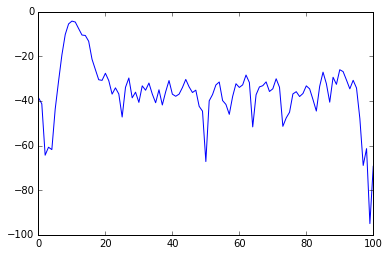

In [25]:
plot(unpackArray(mdf['MSP'][1],data_type=np.float64))

In [26]:
#merge all data items (.mat files) corresponding to site, rec_no and species.

akeys=[]
for file_key in [k for k in data.keys() if k[:3]==master_key[:3]]:

    print file_key,
    tbl=data[file_key]
    array_keys=tbl.keys()
    if len(array_keys)==1:
        time_key=array_keys[0]
    else:
        time_key='MTT'
    
    
    D2=[matlab2datetime(t) for t in np.ravel(tbl[time_key])]
    
    
    if len(D2)==0:
        print 'is empty'
        continue

    S3=pd.Series(data=True,index=D2)
    # Remove from S3 entries with a bad index
    nans=[(a!= None and type(a)!=pd.tslib.NaTType) for a in S3.index]
    S3=S3[nans]
    mdf_key=file_key[-2]+file_key[-1]
    print mdf_key,'read',S3.shape[0],'records'
    akeys.append(mdf_key)
    if mdf_key in mdf.columns:
        print mdf_key,'already in mdf'
    else:
        mdf[mdf_key]=S3
mdf=mdf.fillna(False)
print 'after adding all',mdf.shape
print 'akeys=',akeys

('DT', '01', 'Cuviers', 'FD', '2') FD2 read 922 records
('DT', '01', 'Cuviers', 'TPWS', '2') TPWS2 read 197201 records
('DT', '01', 'Cuviers', 'TPWS', '1') TPWS1 read 274223 records
('DT', '01', 'Cuviers', 'FD', '1') FD1 read 7860 records
('DT', '01', 'Cuviers', 'MD', '1') MD1 read 70321 records
('DT', '01', 'Cuviers', 'MD', '2') is empty
after adding all (274946, 11)
akeys= ['FD2', 'TPWS2', 'TPWS1', 'FD1', 'MD1']


In [27]:
mdf=mdf.sort_index()
mdf[[u'site', u'rec_no', u'species', u'peak2peak']+akeys].head(10)

,site,rec_no,species,peak2peak,FD2,TPWS2,TPWS1,FD1,MD1
2010-08-09 07:01:15.000002,DT,01,Cuviers,45.985810,False,False,True,True,False
2010-08-09 07:02:29.999998,DT,01,Cuviers,44.843157,False,False,True,True,False
2010-08-09 07:03:45.000003,DT,01,Cuviers,45.863097,False,False,True,True,False
2010-08-09 07:05:11.523171,DT,01,Cuviers,54.203887,False,False,True,True,False
2010-08-09 07:06:27.096821,DT,01,Cuviers,53.953768,False,False,True,True,False
2010-08-09 07:06:32.772006,DT,01,Cuviers,49.842384,False,False,True,True,False
2010-08-09 07:06:33.616731,DT,01,Cuviers,49.010330,False,False,True,True,False
2010-08-09 07:06:34.485807,DT,01,Cuviers,47.118755,False,False,True,True,False
2010-08-09 07:06:40.280545,DT,01,Cuviers,48.309630,False,False,True,True,False
2010-08-09 07:06:40.964398,DT,01,Cuviers,51.501142,False,False,True,True,False


In [28]:
#find time gaps (breaks) larger the 1800 seconds = 30 minutes
#these time gaps define what is a recording from a single bout of whales.

times=mdf.index

deltas=np.array([(times[i+1]-times[i]).total_seconds() for i in range(len(times)-1)])

bout_i = np.concatenate([[0],np.cumsum(deltas>1800)])

mdf['bout_i']=bout_i

In [29]:
Flags = pd.DataFrame(mdf[akeys])
Flags['ones']=1
Flags.groupby(akeys).count()

ones
FD2   TPWS2 TPWS1 FD1   MD1          
False False True  False True    69939
                  True  False    7786
                        True       20
      True  False False False     723
            True  False False  195140
                        True      362
                  True  False      54
True  True  True  False False     922

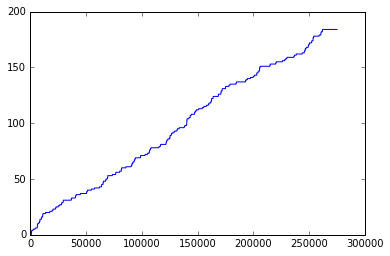

In [30]:
plot (bout_i);

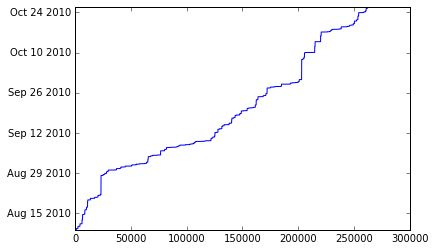

In [31]:
plot(times);

In [32]:
mdf.columns

Index([u'site', u'rec_no', u'species', u'peak2peak', u'MSN', u'MSP', u'FD2',
       u'TPWS2', u'TPWS1', u'FD1', u'MD1', u'bout_i'],
      dtype='object')

In [33]:
mdf=mdf[[u'site', u'rec_no', u'bout_i', u'species', u'peak2peak','MSN','MSP']+akeys]
mdf.head()

,site,rec_no,bout_i,species,peak2peak,MSN,MSP,FD2,TPWS2,TPWS1,FD1,MD1
2010-08-09 07:01:15.000002,DT,01,0,Cuviers,45.985810,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[180, 196, 7, 138, 165, 28, 65, 192, 18, 240, ...",False,False,True,True,False
2010-08-09 07:02:29.999998,DT,01,0,Cuviers,44.843157,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[84, 0, 16, 72, 93, 160, 65, 192, 118, 53, 42,...",False,False,True,True,False
2010-08-09 07:03:45.000003,DT,01,0,Cuviers,45.863097,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[67, 227, 115, 122, 1, 223, 64, 192, 235, 234,...",False,False,True,True,False
2010-08-09 07:05:11.523171,DT,01,0,Cuviers,54.203887,"[240, 213, 200, 89, 189, 43, 16, 192, 0, 226, ...","[44, 106, 239, 80, 161, 102, 65, 192, 96, 105,...",False,False,True,True,False
2010-08-09 07:06:27.096821,DT,01,0,Cuviers,53.953768,"[64, 95, 23, 103, 183, 17, 21, 192, 224, 168, ...","[42, 38, 133, 226, 139, 135, 66, 192, 136, 97,...",False,False,True,True,False


In [34]:
def packed2cvs(row, data_type=np.float64,fmt='%6.4f'):
    return ','.join([fmt%x for x in list(unpackArray(row,data_type=data_type))])
packed2cvs(mdf['MSP'][1])

'-35.2528,-35.0435,-46.4771,-49.8702,-50.1851,-48.7973,-33.8817,-24.9540,-19.3585,-16.5317,-15.8172,-16.3975,-17.3719,-17.7369,-17.6556,-17.9082,-18.2148,-18.8320,-19.5688,-19.1760,-18.8469,-20.0967,-20.9053,-20.6163,-21.8672,-22.1504,-22.2318,-22.8896,-21.9784,-22.3762,-23.8167,-23.0124,-21.6222,-21.8216,-24.1648,-27.8420,-27.2391,-24.8876,-24.0436,-24.3730,-24.8900,-25.3223,-26.1830,-25.6344,-24.5404,-25.2670,-27.4257,-30.4422,-31.8927,-29.3916,-27.2991,-25.7257,-25.6982,-27.3833,-28.5848,-29.2403,-31.4937,-31.5888,-28.6602,-26.8062,-26.2541,-26.7075,-27.3277,-27.8395,-29.2882,-30.8081,-29.3463,-26.1469,-24.2931,-24.1431,-25.5900,-29.4158,-31.8303,-28.2881,-27.4818,-28.9584,-32.5434,-36.0896,-28.4966,-25.5702,-24.3769,-24.5974,-28.1669,-35.0698,-35.3643,-30.9863,-27.6685,-26.5005,-25.9734,-25.7509,-26.8151,-30.7129,-35.8730,-32.2192,-31.2438,-33.3672,-38.0414,-46.4163,-63.5005,-74.7820,-70.9636'

In [35]:
mdf.columns

Index([u'site', u'rec_no', u'bout_i', u'species', u'peak2peak', u'MSN', u'MSP',
       u'FD2', u'TPWS2', u'TPWS1', u'FD1', u'MD1'],
      dtype='object')

In [37]:
row=mdf.ix[0,:]
lrow=list(row)
#print row
pos=1
print "0: time of click"
for i in range(len(row)):
    a=row[i]
    name=row.index[i]
    if type(row[i])!=bytearray:
        print ' %5d: %s\t\t\t\t%s'%(pos,name,str(type(a)))
        pos+=1
    else:
        print " %5d: %s\t\t\t\t an array of length %d"%(pos,name,len(a)/8)
        pos+=len(a)/8

print "total number of fields=",pos

0: time of click
     1: site				<type 'str'>
     2: rec_no				<type 'str'>
     3: bout_i				<type 'numpy.int64'>
     4: species				<type 'str'>
     5: peak2peak				<type 'numpy.float64'>
     6: MSN				 an array of length 202
   208: MSP				 an array of length 101
   309: FD2				<type 'numpy.bool_'>
   310: TPWS2				<type 'numpy.bool_'>
   311: TPWS1				<type 'numpy.bool_'>
   312: FD1				<type 'numpy.bool_'>
   313: MD1				<type 'numpy.bool_'>
total number of fields= 314


In [38]:
def row2cvs(T,lrow,fmt='%6.4f',date_format='%Y-%m-%d %H:%M:%S.%f'):
    L=[dt.datetime.strftime(T,date_format)]
    for x in lrow:
        #print type(x)
        if type(x)==type('string'):
            L.append(x)
        elif type(x)==np.float64:
            L.append(fmt%x)
        elif type(x)==np.bool_:
            L.append('%1d'%(1*x))
        elif type(x)==numpy.int64:
            L.append(str(x))
        elif type(x)==bytearray:
            L.append(packed2cvs(x))
        else:
            raise Exception('row2cvs error: unrecognized type='+str(type(x)))
    return ','.join(L)+'\n'
row2cvs(T,lrow)

NameError: name 'T' is not defined

|field name     | Description               | Data Type
|---------------|---------------------------|--------------
|0: time        | time of click             | string in datetime format `%Y-%m-%d %H:%M:%S.%f`
|1: site		| name of site		        | 'str'
|2: rec_no		| recording number		    | 'str'
|3: bout_i		| bout number		        | numpy.int64
|4: species		| Initial species classification	        | 'str'
|5: peak2peak	| peak to peak magnitude    | 			numpy.float64
|6: TPWS1		| 1 if click appears in TPWS1	| 	bool
|7: TPWS2		| 1 if click appears in TPWS2	| bool
|     8: FD1	|	--- " ---	|	bool
|    9: FD2		|	--- " ---   |	bool
|    10: MD1		|	--- " ---	|	bool
|   11: MD2		|	--- " ---	|	bool
|   12: MSP		|	energy as function of frequency |	 an array of length 101  
|   113: MSN	|	wave form |		 an array of length 202
total number of fields= 315

In [61]:
cvs_dirname='.'.join(master_key)
cvs_dirname

'DT.01.Cuviers'

In [81]:
cvs=0
_len = mdf.shape[0]
print 'total length=',_len
_current_bout=-1
for i in range(_len):
    row=mdf.ix[i,:]
    if row['bout_i']!=_current_bout:
        if cvs!=0:
            cvs.close()
            s3helper.local_to_s3(cvs_filename,'CVS/'+cvs_dirname+'/'+cvs_filename)
            !rm $cvs_filename

        _current_bout=row['bout_i']
        cvs_filename = cvs_dirname+"."+str(_current_bout)+'.cvs'
        # print cvs_filename,'CVS/'+cvs_dirname+'/'+cvs_filename
        print '\r Percent processed %5.2f \tbout_no=%d'%((i+0.0)/_len*100,_current_bout),
        cvs=open(cvs_filename,'w')
                                                           
    T=mdf.index[i]
    cvs.write(row2cvs(T,row))
cvs.close()
s3helper.local_to_s3(cvs_filename,'CVS/'+cvs_dirname+'/'+cvs_filename)
print 'done'

total length= 274946
 Percent processed 95.24 	bout_no=184 done


In [82]:
!pwd
print cvs_filename
!ls -l *.cvs

/mnt/whales/DT_Cuviers
DT.01.Cuviers.184.cvs
-rw-r--r-- 1 root root  2629774 Aug 28 21:55 DT.01.Cuviers.0.cvs
-rw-r--r-- 1 root root    99611 Aug 28 21:56 DT.01.Cuviers.100.cvs
-rw-r--r-- 1 root root    79269 Aug 28 21:56 DT.01.Cuviers.101.cvs
-rw-r--r-- 1 root root   172148 Aug 28 21:56 DT.01.Cuviers.102.cvs
-rw-r--r-- 1 root root   389600 Aug 28 21:56 DT.01.Cuviers.103.cvs
-rw-r--r-- 1 root root  4330797 Aug 28 21:56 DT.01.Cuviers.104.cvs
-rw-r--r-- 1 root root  2899322 Aug 28 21:56 DT.01.Cuviers.105.cvs
-rw-r--r-- 1 root root   224744 Aug 28 21:56 DT.01.Cuviers.106.cvs
-rw-r--r-- 1 root root  2190863 Aug 28 21:56 DT.01.Cuviers.107.cvs
-rw-r--r-- 1 root root  7298495 Aug 28 21:56 DT.01.Cuviers.108.cvs
-rw-r--r-- 1 root root   805064 Aug 28 21:56 DT.01.Cuviers.109.cvs
-rw-r--r-- 1 root root  2734112 Aug 28 21:55 DT.01.Cuviers.10.cvs
-rw-r--r-- 1 root root  1290544 Aug 28 21:56 DT.01.Cuviers.110.cvs
-rw-r--r-- 1 root root  2443396 Aug 28 21:56 DT.01.Cuviers.111.cvs
-rw-r--r-- 1 root ro

In [67]:
print cvs_filename,'CVS/'+cvs_dirname+'/'+cvs_filename
s3helper.local_to_s3(cvs_filename,'CVS/'+cvs_dirname+'/'+cvs_filename)

DT.01.Cuviers.1.cvs CVS/DT.01.Cuviers/DT.01.Cuviers.1.cvs


Exception: File does not exist.

In [63]:
!rm DT.01.Cuviers.*

In [71]:
s3helper.ls_s3('CVS')

[u'CVS/DT.01.Cuviers']

In [53]:
!wc *


         0          0          0 DT.01.Cuviers.cvs
      1011       2022    2629774 DT.01.Cuviers.cvs0.cvs
        39         78      99611 DT.01.Cuviers.cvs100.cvs
        31         62      79269 DT.01.Cuviers.cvs101.cvs
        67        134     172148 DT.01.Cuviers.cvs102.cvs
       149        298     389600 DT.01.Cuviers.cvs103.cvs
      1657       3314    4330797 DT.01.Cuviers.cvs104.cvs
      1125       2250    2899322 DT.01.Cuviers.cvs105.cvs
        88        176     224744 DT.01.Cuviers.cvs106.cvs
       849       1698    2190863 DT.01.Cuviers.cvs107.cvs
      2874       5748    7298495 DT.01.Cuviers.cvs108.cvs
       315        630     805064 DT.01.Cuviers.cvs109.cvs
      1053       2106    2734112 DT.01.Cuviers.cvs10.cvs
       501       1002    1290544 DT.01.Cuviers.cvs110.cvs
       950       1900    2443396 DT.01.Cuviers.cvs111.cvs
      1995       3990    5240866 DT.01.Cuviers.cvs112.cvs
      3225       6450    8361976 DT.01.Cuviers.cvs113.cvs
      1435       2870   

In [54]:
s3helper.local_to_s3('DT.01.Cuviers.cvs101.cvs','CVS/DT.01.Cuviers/DT.01.Cuviers.cvs101.cvs')